In [2]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('model_matchups_finalfour_classic_historical.csv')
print(df.shape)
df.head()

(45, 80)


,game_id,id,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,high_bracket_score,...,d_b,d_c,d_d,d_f,f_s,f_a,f_b,f_c,f_d,f_f
0,20085516,5516,2008,Final Four,Final Four,1,2008 North Carolina,1,2008 Kansas,66,...,0,0,0,0,0,0,0,0,0,0
1,20085517,5517,2008,Final Four,Final Four,1,2008 Memphis,1,2008 UCLA,78,...,0,0,0,0,0,0,0,0,0,0
2,20085618,5618,2008,Final Four,Championship,1,2008 Kansas,1,2008 Memphis,75,...,0,0,0,0,0,0,0,0,0,0
3,20095516,5516,2009,Final Four,Final Four,2,2009 Michigan St.,1,2009 Connecticut,82,...,0,0,0,0,0,0,0,0,0,0
4,20095618,5618,2009,Final Four,Championship,2,2009 Michigan St.,1,2009 North Carolina,72,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.columns.to_list()

['game_id',
 'id',
 'year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'high_bracket_score',
 'low_bracket_score',
 'point_diff',
 'point_total',
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_s',
 's_a',
 's_b',
 's_c',
 's_d',
 's_f',
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'a_d',
 'a_f',
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'b_d',
 'b_f',
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f',
 'd_s',
 'd_a',
 'd_b',
 'd_c',
 'd_d',
 'd_f',
 'f_s',
 'f_a',
 'f_b',
 'f_c',
 'f_d',
 'f_f']

In [4]:
df['win'].value_counts()

0    26
1    19
Name: win, dtype: int64

# I. Check Tiers

In [5]:
s_tiers = df[[
 's_s',
 's_a',
 's_b',
 's_c',
 's_d',
 's_f']]
print(s_tiers.value_counts())
a_tiers = df[[
 'a_s',
 'a_a',
 'a_b',
 'a_c',
 'a_d',
 'a_f']]
print(a_tiers.value_counts())
b_tiers = df[[
 'b_s',
 'b_a',
 'b_b',
 'b_c',
 'b_d',
 'b_f']]
print(b_tiers.value_counts())
c_tiers = df[[
 'c_s',
 'c_a',
 'c_b',
 'c_c',
 'c_d',
 'c_f']]
print(c_tiers.value_counts())
d_tiers = df[[
 'd_s',
 'd_a',
 'd_b',
 'd_c',
 'd_d',
 'd_f']]
print(d_tiers.value_counts())
f_tiers = df[[
 'f_s',
 'f_a',
 'f_b',
 'f_c',
 'f_d',
 'f_f']]
print(f_tiers.value_counts())

s_s  s_a  s_b  s_c  s_d  s_f
0    0    0    0    0    0      22
1    0    0    0    0    0      13
0    0    1    0    0    0       4
          0    1    0    0       3
     1    0    0    0    0       3
dtype: int64
a_s  a_a  a_b  a_c  a_d  a_f
0    0    0    0    0    0      34
1    0    0    0    0    0       7
0    0    0    1    0    0       3
     1    0    0    0    0       1
dtype: int64
b_s  b_a  b_b  b_c  b_d  b_f
0    0    0    0    0    0      43
1    0    0    0    0    0       2
dtype: int64
c_s  c_a  c_b  c_c  c_d  c_f
0    0    0    0    0    0      37
1    0    0    0    0    0       4
0    0    1    0    0    0       2
     1    0    0    0    0       2
dtype: int64
d_s  d_a  d_b  d_c  d_d  d_f
0    0    0    0    0    0      44
               1    0    0       1
dtype: int64
f_s  f_a  f_b  f_c  f_d  f_f
0    0    0    0    0    0      45
dtype: int64


In [6]:
# Remove all tier matchups that happened three or less times and view win percentage of the the remaining tiers
all_tiers = df[[
 'win',
 's_s',
 's_b',
 'a_s',
 'c_s']]

In [10]:
all_tiers.groupby(by=['win', 's_s']).size()

win  s_s
0    0      17
     1       9
1    0      15
     1       4
dtype: int64

In [11]:
all_tiers.groupby(by=['win', 's_b']).size()

win  s_b
0    0      26
1    0      15
     1       4
dtype: int64

In [12]:
all_tiers.groupby(by=['win', 'a_s']).size()

win  a_s
0    0      20
     1       6
1    0      18
     1       1
dtype: int64

In [13]:
all_tiers.groupby(by=['win', 'c_s']).size()

win  c_s
0    0      22
     1       4
1    0      19
dtype: int64

In [14]:
# Remove any tier with win percentages under 80% and greater than 20% and keep only columns that can be included in a model
eda_df = df[[
 'win',
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_b',
 'a_s',
 'c_s']]
eda_df.shape

(45, 34)

In [15]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape

((36, 33), (9, 33))

In [16]:
y_train.shape, y_test.shape

((36,), (9,))

In [17]:
X_train.head()

,ovr_rating_bpi,ovr_rating_kenpom,ovr_rating_torvik,wab,off_rating_bpi,off_rating_kenpom,off_rating_torvik,def_rating_bpi,def_rating_kenpom,def_rating_torvik,...,3p%_def,eff_def,ft%_def,height_eff,size,bench,adj_tempo,s_b,a_s,c_s
31,6.3000,8.1703,0.0253,2.4009,10.3000,25.0234,22.8762,-3.9000,-16.7391,-16.5934,...,-7.5000,-16.1237,5.2000,-1.5100,-0.3700,5.0000,0.1000,1,0,0
29,1.0000,5.0447,0.0174,-0.6301,2.6000,14.4020,11.8695,-1.8000,-7.9941,-7.0597,...,-6.7000,-30.0623,-4.9000,1.6200,0.5700,-4.6400,-1.2000,0,0,0
20,-6.5000,-8.6944,-0.0615,-6.9697,-9.7000,-1.7600,-1.0165,3.3000,-7.8014,-8.0695,...,-3.9000,-16.1492,0.4000,2.6200,0.0300,-1.7300,2.7000,0,0,0
41,-4.3000,-9.4461,-0.0849,-6.1512,1.1000,6.5568,5.1336,-5.4000,-16.3077,-15.9396,...,-0.6000,-10.6310,1.3000,1.3100,1.1200,-4.9900,0.7000,0,0,1
2,2.6000,4.5868,0.0119,1.0022,4.4000,4.2229,1.6239,-1.7000,-0.3676,3.5539,...,-1.0000,-23.4579,8.1000,0.1700,-0.8800,-2.0600,-1.8000,0,0,0


In [18]:
X_train.columns.to_list()

['ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo',
 's_b',
 'a_s',
 'c_s']

# II. Box Plots

<Axes: xlabel='win', ylabel='ovr_rating_bpi'>

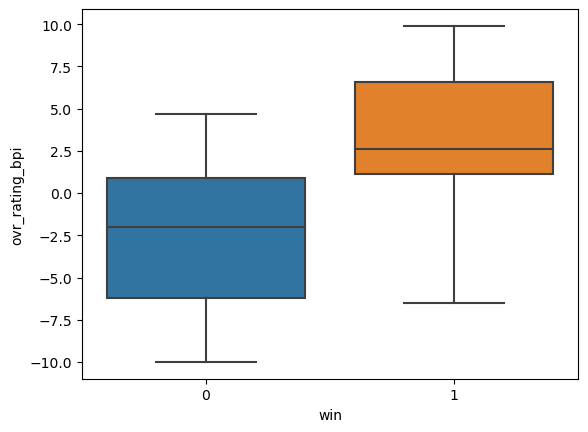

In [19]:
sns.boxplot(data=df, x='win', y='ovr_rating_bpi')

<Axes: xlabel='win', ylabel='ovr_rating_kenpom'>

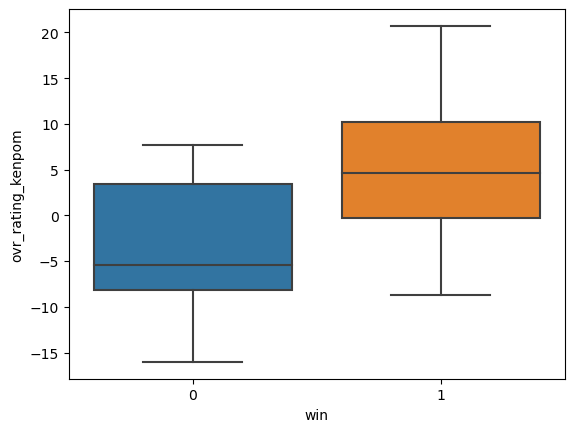

In [20]:
sns.boxplot(data=df, x='win', y='ovr_rating_kenpom')

<Axes: xlabel='win', ylabel='ovr_rating_torvik'>

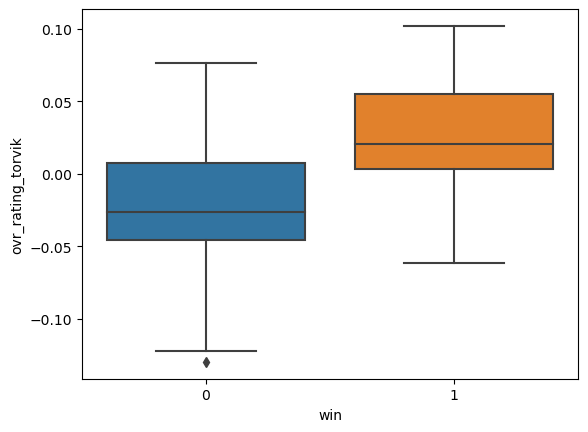

In [21]:
sns.boxplot(data=df, x='win', y='ovr_rating_torvik')

<Axes: xlabel='win', ylabel='wab'>

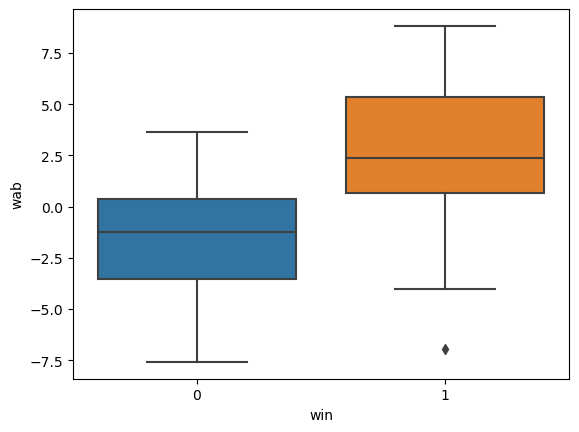

In [22]:
sns.boxplot(data=df, x='win', y='wab')

<Axes: xlabel='win', ylabel='off_rating_bpi'>

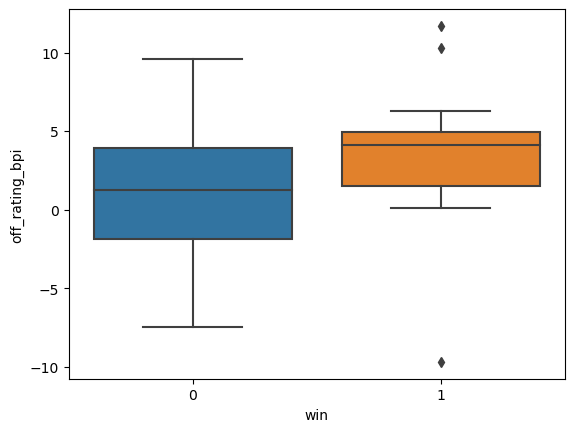

In [23]:
sns.boxplot(data=df, x='win', y='off_rating_bpi')

<Axes: xlabel='win', ylabel='off_rating_kenpom'>

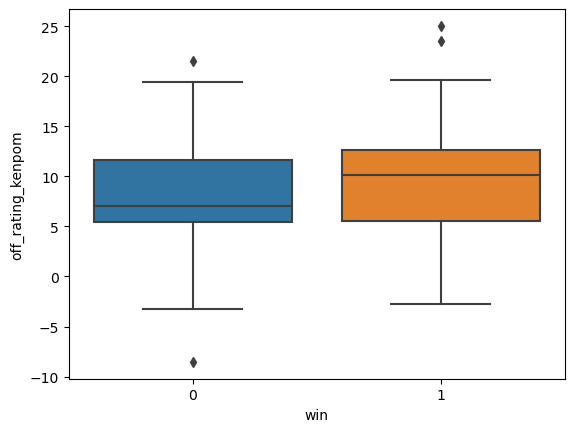

In [24]:
sns.boxplot(data=df, x='win', y='off_rating_kenpom')

<Axes: xlabel='win', ylabel='off_rating_torvik'>

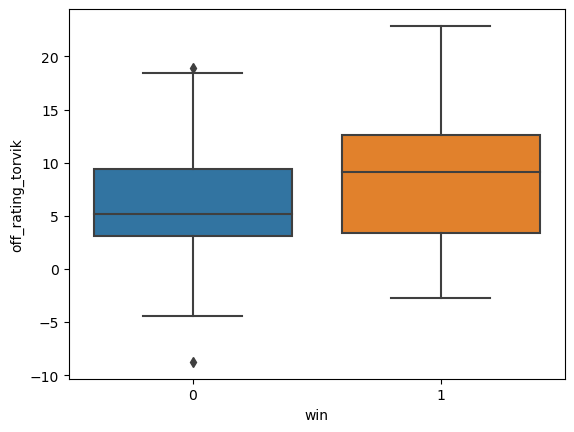

In [25]:
sns.boxplot(data=df, x='win', y='off_rating_torvik')

<Axes: xlabel='win', ylabel='def_rating_bpi'>

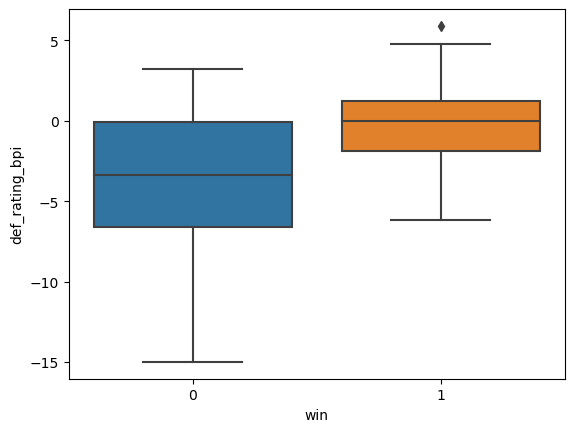

In [26]:
sns.boxplot(data=df, x='win', y='def_rating_bpi')

<Axes: xlabel='win', ylabel='def_rating_kenpom'>

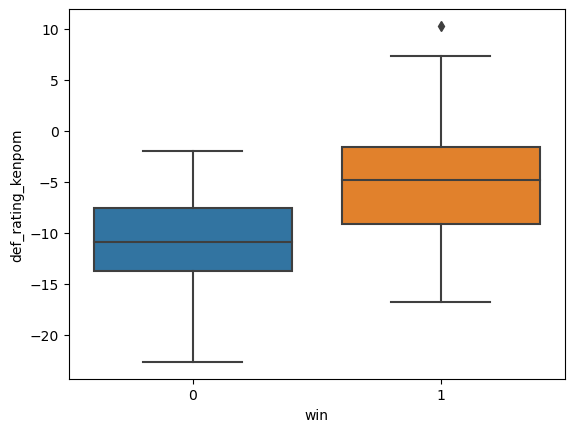

In [27]:
sns.boxplot(data=df, x='win', y='def_rating_kenpom')

<Axes: xlabel='win', ylabel='def_rating_torvik'>

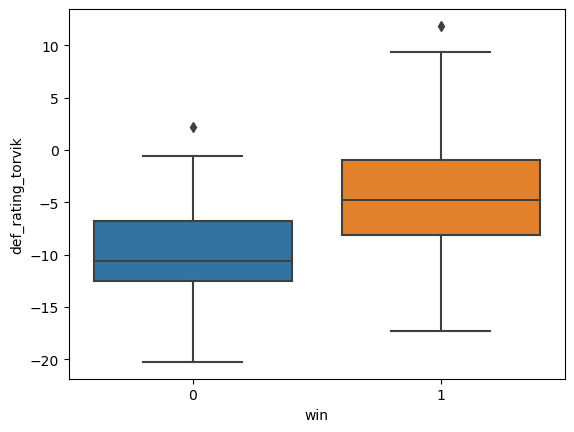

In [28]:
sns.boxplot(data=df, x='win', y='def_rating_torvik')

<Axes: xlabel='win', ylabel='efg%_off'>

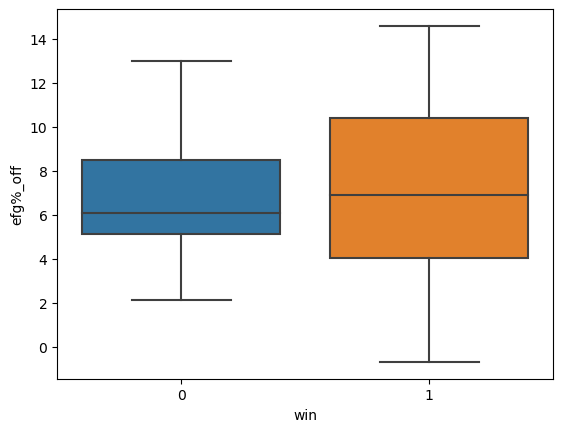

In [29]:
sns.boxplot(data=df, x='win', y='efg%_off')

<Axes: xlabel='win', ylabel='ftr_off'>

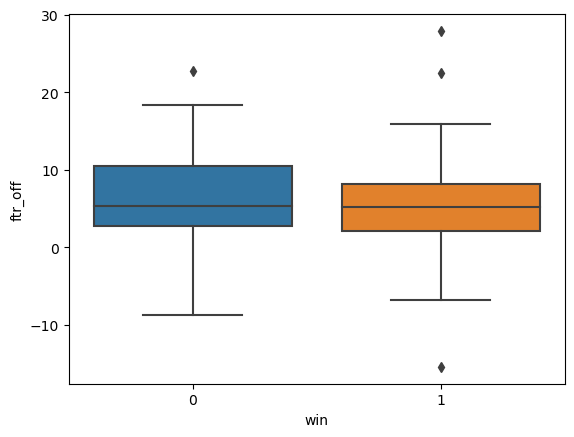

In [30]:
sns.boxplot(data=df, x='win', y='ftr_off')

<Axes: xlabel='win', ylabel='reb%_off'>

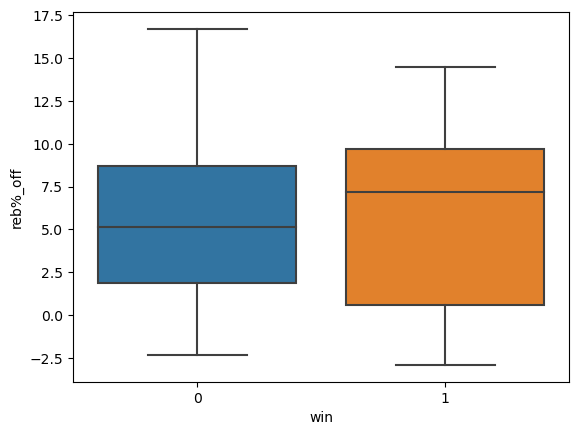

In [31]:
sns.boxplot(data=df, x='win', y='reb%_off')

<Axes: xlabel='win', ylabel='to%_off'>

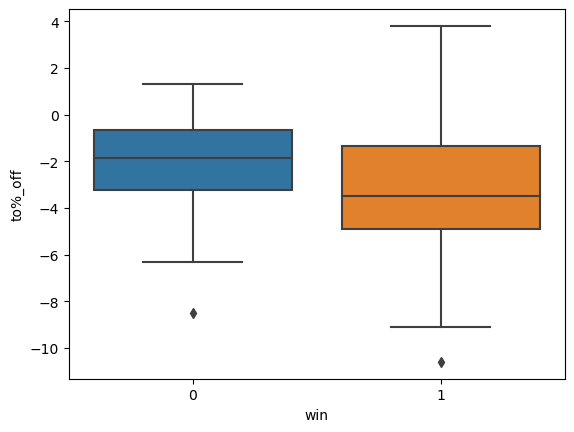

In [32]:
sns.boxplot(data=df, x='win', y='to%_off')

<Axes: xlabel='win', ylabel='efg%_def'>

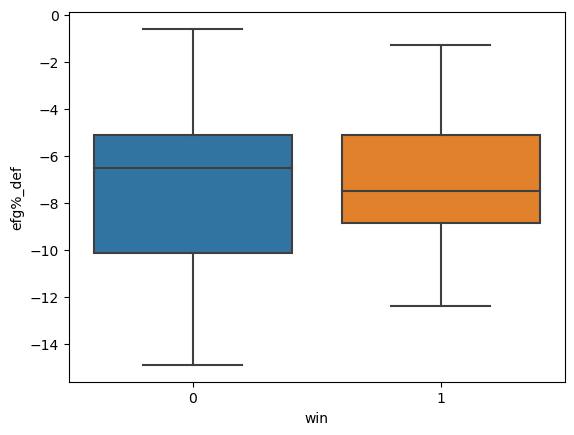

In [33]:
sns.boxplot(data=df, x='win', y='efg%_def')

<Axes: xlabel='win', ylabel='ftr_def'>

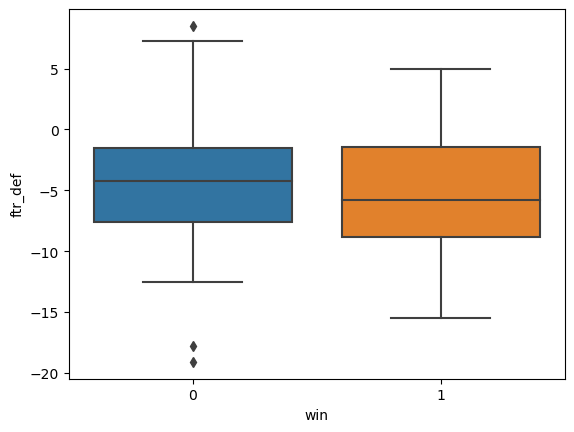

In [34]:
sns.boxplot(data=df, x='win', y='ftr_def')

<Axes: xlabel='win', ylabel='reb%_def'>

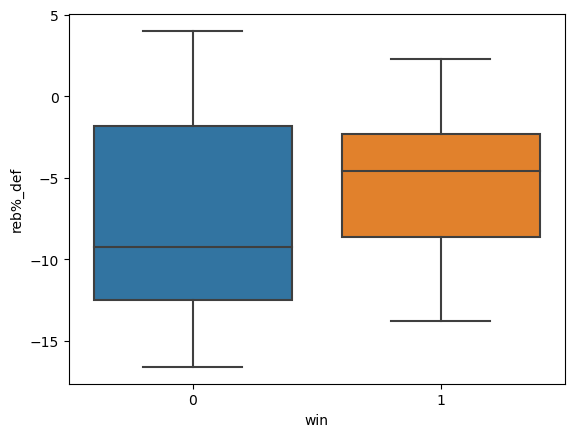

In [35]:
sns.boxplot(data=df, x='win', y='reb%_def')

<Axes: xlabel='win', ylabel='to%_def'>

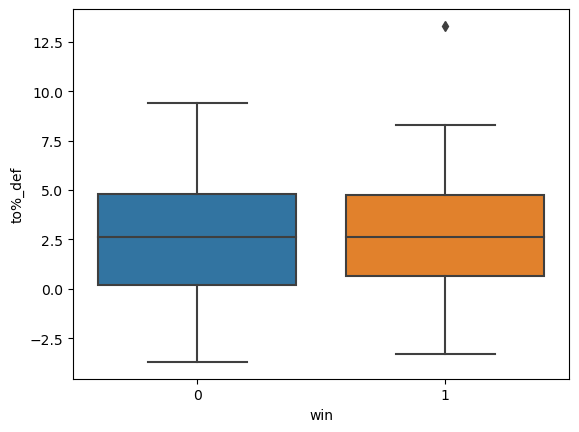

In [36]:
sns.boxplot(data=df, x='win', y='to%_def')

<Axes: xlabel='win', ylabel='2p%_off'>

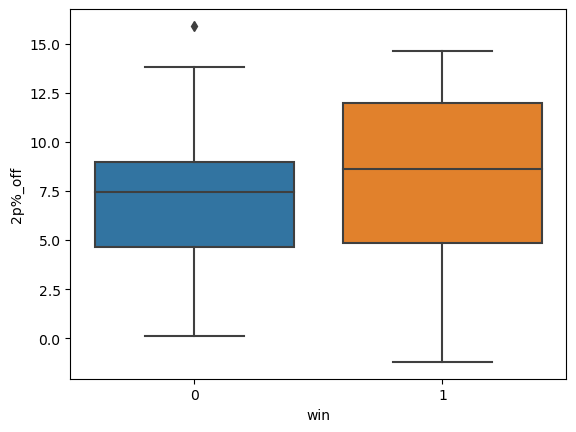

In [37]:
sns.boxplot(data=df, x='win', y='2p%_off')

<Axes: xlabel='win', ylabel='3p%_off'>

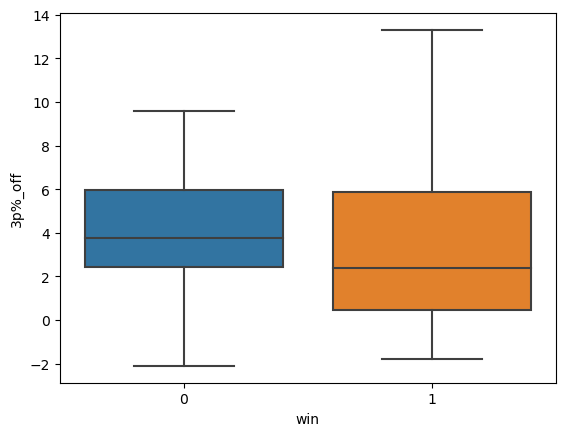

In [38]:
sns.boxplot(data=df, x='win', y='3p%_off')

<Axes: xlabel='win', ylabel='eff_off'>

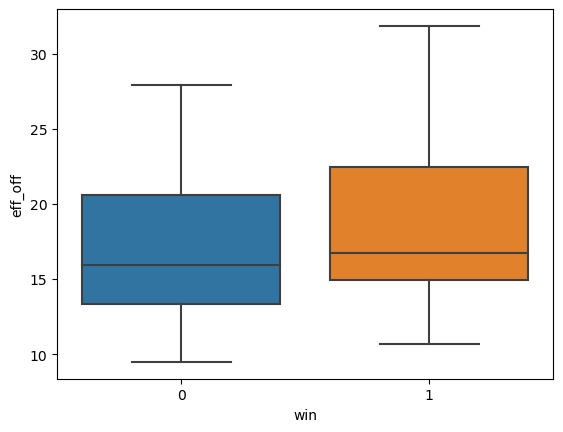

In [39]:
sns.boxplot(data=df, x='win', y='eff_off')

<Axes: xlabel='win', ylabel='ft%_off'>

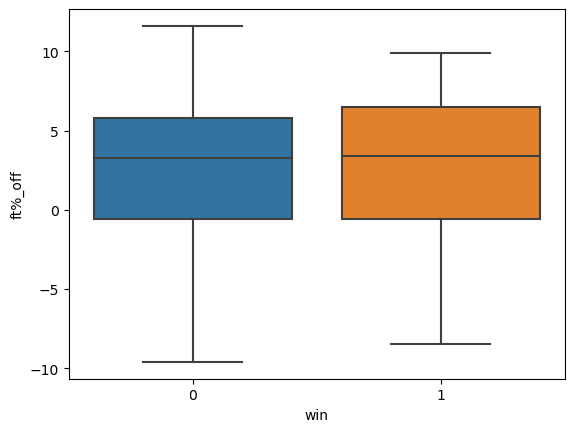

In [40]:
sns.boxplot(data=df, x='win', y='ft%_off')

<Axes: xlabel='win', ylabel='2p%_def'>

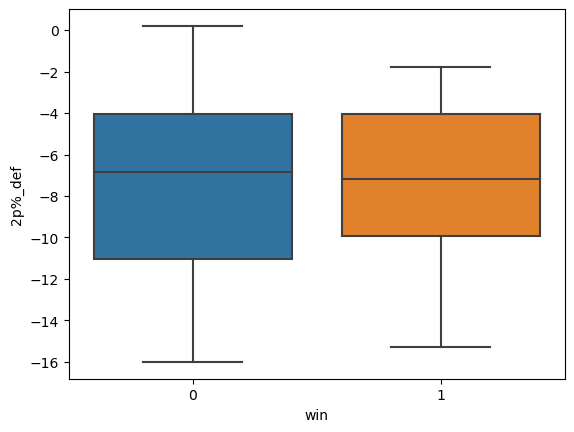

In [41]:
sns.boxplot(data=df, x='win', y='2p%_def')

<Axes: xlabel='win', ylabel='3p%_def'>

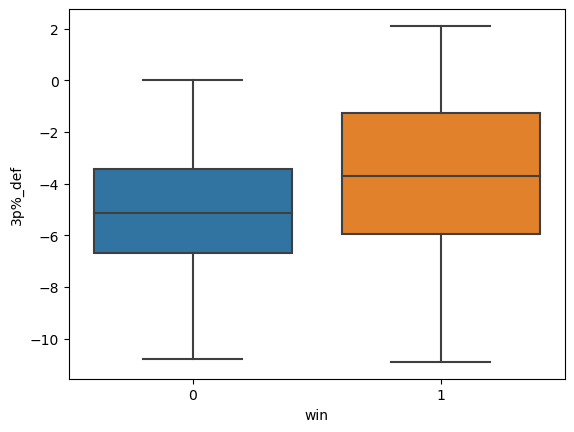

In [42]:
sns.boxplot(data=df, x='win', y='3p%_def')

<Axes: xlabel='win', ylabel='eff_def'>

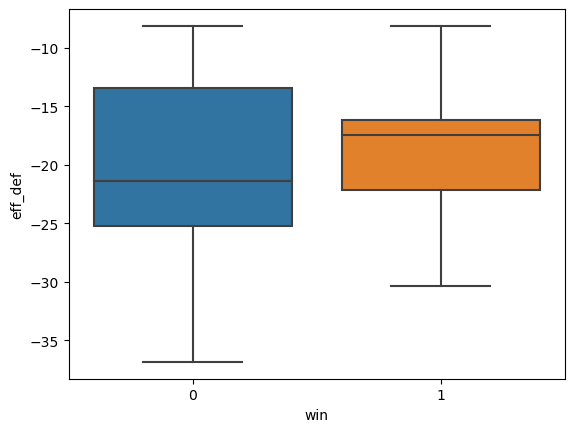

In [43]:
sns.boxplot(data=df, x='win', y='eff_def')

<Axes: xlabel='win', ylabel='ft%_def'>

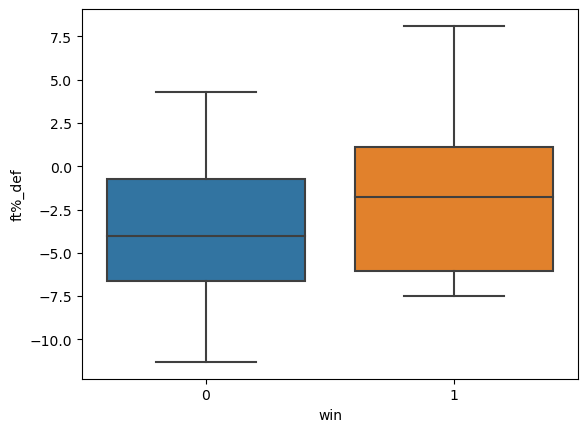

In [44]:
sns.boxplot(data=df, x='win', y='ft%_def')

<Axes: xlabel='win', ylabel='height_eff'>

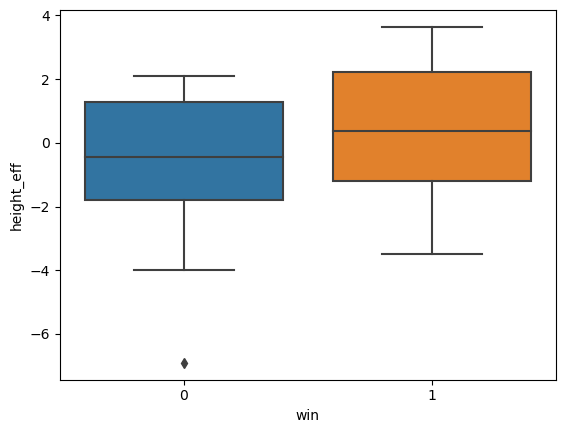

In [45]:
sns.boxplot(data=df, x='win', y='height_eff')

<Axes: xlabel='win', ylabel='size'>

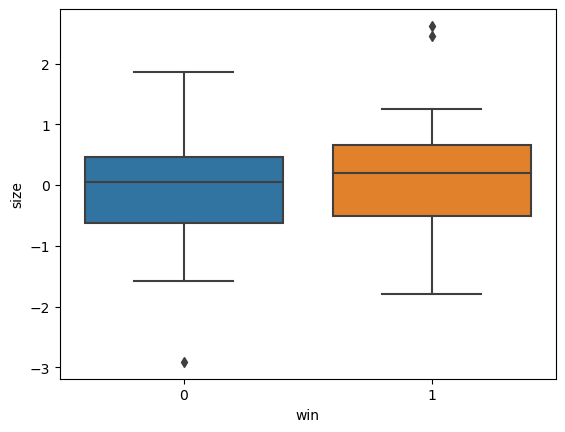

In [46]:
sns.boxplot(data=df, x='win', y='size')

<Axes: xlabel='win', ylabel='bench'>

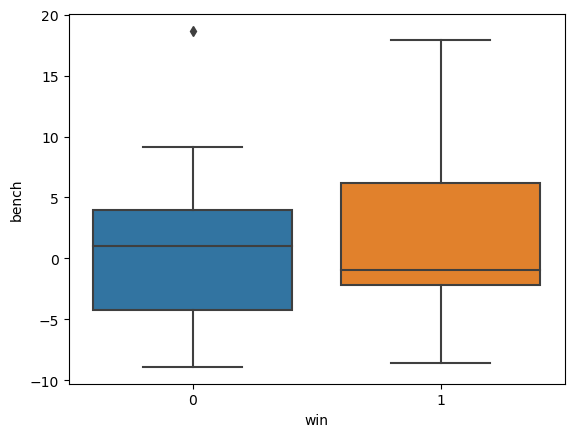

In [47]:
sns.boxplot(data=df, x='win', y='bench')

<Axes: xlabel='win', ylabel='adj_tempo'>

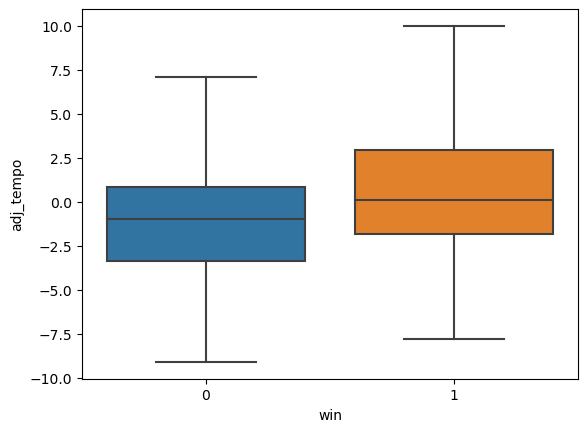

In [48]:
sns.boxplot(data=df, x='win', y='adj_tempo')

# III. Mutual Information

Text(0, 0.5, 'Mutual Information')

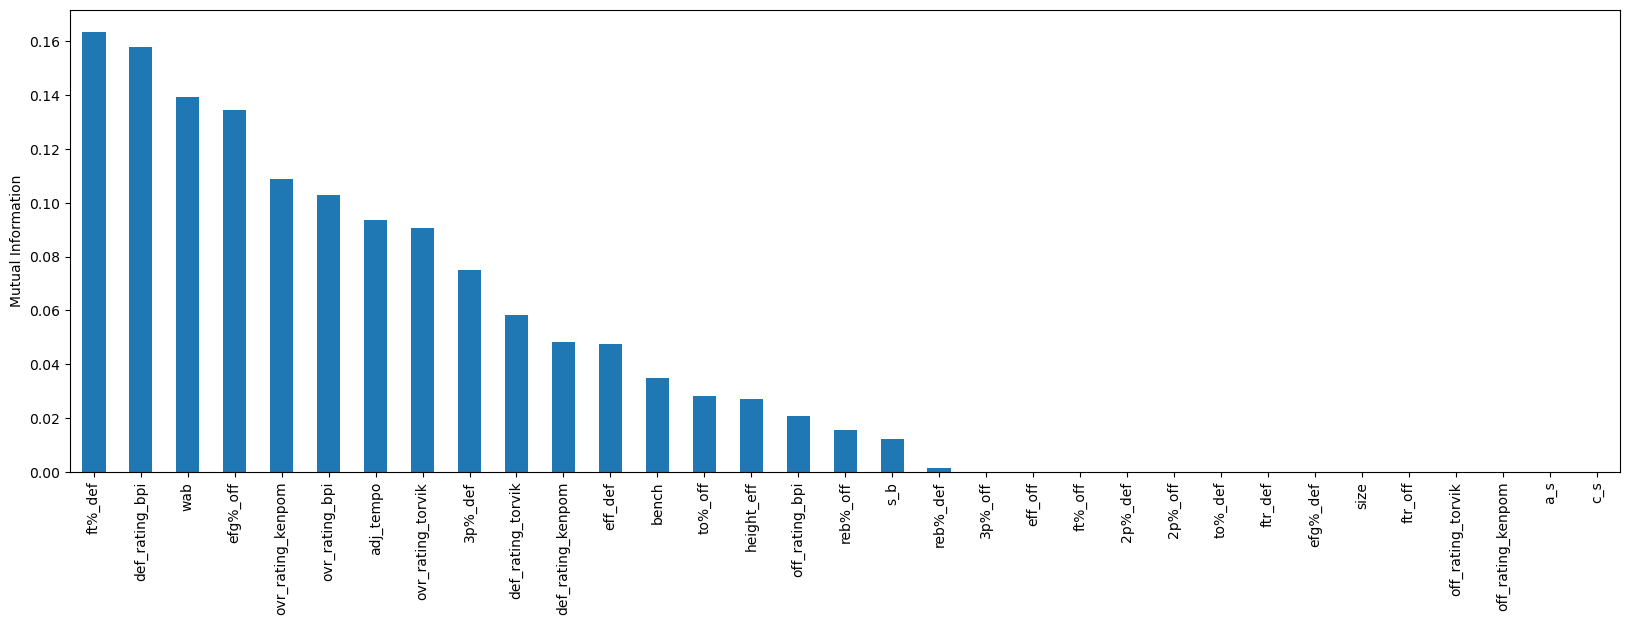

In [49]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [50]:
mi

ovr_rating_bpi      0.1029
ovr_rating_kenpom   0.1089
ovr_rating_torvik   0.0906
wab                 0.1394
off_rating_bpi      0.0207
off_rating_kenpom   0.0000
off_rating_torvik   0.0000
def_rating_bpi      0.1579
def_rating_kenpom   0.0481
def_rating_torvik   0.0583
efg%_off            0.1344
ftr_off             0.0000
reb%_off            0.0157
to%_off             0.0280
efg%_def            0.0000
ftr_def             0.0000
reb%_def            0.0012
to%_def             0.0000
2p%_off             0.0000
3p%_off             0.0000
eff_off             0.0000
ft%_off             0.0000
2p%_def             0.0000
3p%_def             0.0748
eff_def             0.0473
ft%_def             0.1636
height_eff          0.0270
size                0.0000
bench               0.0349
adj_tempo           0.0936
s_b                 0.0121
a_s                 0.0000
c_s                 0.0000
dtype: float64

In [51]:
sel_ = SelectKBest(f_classif, k=10).fit(X_train, y_train)
X_train.columns[sel_.get_support()]

Index(['ovr_rating_bpi', 'ovr_rating_kenpom', 'ovr_rating_torvik', 'wab',
       'def_rating_bpi', 'def_rating_kenpom', 'def_rating_torvik', 'reb%_def',
       'ft%_def', 's_b'],
      dtype='object')

# IV. ANOVA

In [53]:
X_num = X_train[[
 'ovr_rating_bpi',
 'ovr_rating_kenpom',
 'ovr_rating_torvik',
 'wab',
 'off_rating_bpi',
 'off_rating_kenpom',
 'off_rating_torvik',
 'def_rating_bpi',
 'def_rating_kenpom',
 'def_rating_torvik',
 'efg%_off',
 'ftr_off',
 'reb%_off',
 'to%_off',
 'efg%_def',
 'ftr_def',
 'reb%_def',
 'to%_def',
 '2p%_off',
 '3p%_off',
 'eff_off',
 'ft%_off',
 '2p%_def',
 '3p%_def',
 'eff_def',
 'ft%_def',
 'height_eff',
 'size',
 'bench',
 'adj_tempo']]

X_cat = X_train[[
     's_b',
     'a_s',
     'c_s']]

<Axes: >

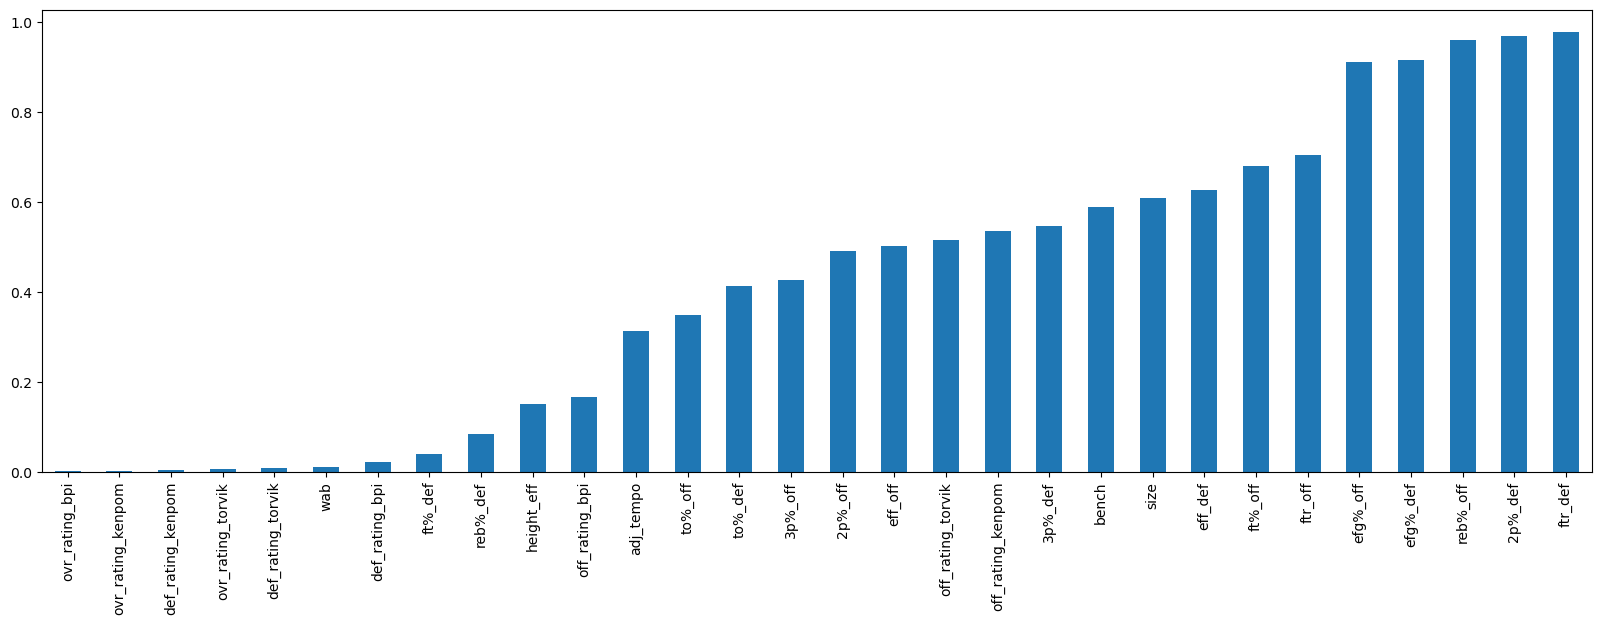

In [54]:
univariate = f_classif(X_num, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_num.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20, 6))

In [55]:
univariate

ovr_rating_bpi      0.0009
ovr_rating_kenpom   0.0025
ovr_rating_torvik   0.0069
wab                 0.0112
off_rating_bpi      0.1652
off_rating_kenpom   0.5348
off_rating_torvik   0.5151
def_rating_bpi      0.0216
def_rating_kenpom   0.0047
def_rating_torvik   0.0079
efg%_off            0.9117
ftr_off             0.7033
reb%_off            0.9596
to%_off             0.3492
efg%_def            0.9147
ftr_def             0.9787
reb%_def            0.0848
to%_def             0.4128
2p%_off             0.4918
3p%_off             0.4259
eff_off             0.5027
ft%_off             0.6809
2p%_def             0.9688
3p%_def             0.5462
eff_def             0.6254
ft%_def             0.0394
height_eff          0.1506
size                0.6078
bench               0.5886
adj_tempo           0.3132
dtype: float64

In [57]:
sel_ = SelectKBest(f_classif, k=8).fit(X_num, y_train)
X_num.columns[sel_.get_support()]

Index(['ovr_rating_bpi', 'ovr_rating_kenpom', 'ovr_rating_torvik', 'wab',
       'def_rating_bpi', 'def_rating_kenpom', 'def_rating_torvik', 'ft%_def'],
      dtype='object')

# V. Chi Squared

In [58]:
chi_ls = []

for feature in X_cat.columns:
    c = pd.crosstab(y_train, X_cat[feature])
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

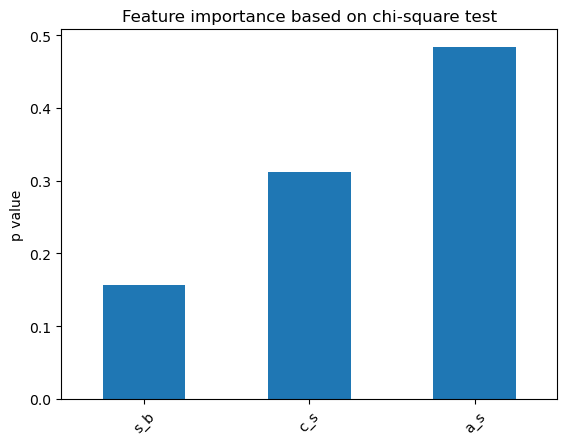

In [59]:
pd.Series(chi_ls, index=X_cat.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [60]:
chi_ls

[0.1568282969261731, 0.4836396538634655, 0.31187296478601956]

# VI. Lasso Regression

In [61]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [62]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [63]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 33
selected features: 8
features with coefficients shrank to zero: 25


In [64]:
selected_feat

Index(['ovr_rating_bpi', 'def_rating_kenpom', 'ftr_off', 'reb%_def', 'to%_def',
       'ft%_off', 'ft%_def', 's_b'],
      dtype='object')

# VII. Backward Selection

In [102]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=5,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [103]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [104]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['ovr_rating_bpi', 'ovr_rating_torvik', 'to%_off', 'ftr_def', 'c_s'],
      dtype=object)

In [105]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.996875
Test set
Random Forests roc-auc: 0.8333333333333334


In [106]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 1.0
Test set
Random Forests roc-auc: 0.888888888888889


### Sample size is so small a fancy model is overkill. The better team will win.

# IX. ROC-AUC

In [107]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.9166666666666667,
 0.6666666666666666,
 0.5,
 0.75,
 0.75,
 0.5833333333333334,
 0.75,
 0.5,
 0.5,
 0.5,
 0.5555555555555556,
 0.25,
 0.5555555555555556,
 0.3888888888888889,
 0.3333333333333333,
 0.4166666666666667,
 0.33333333333333337,
 0.08333333333333331,
 0.8333333333333334,
 0.9166666666666667,
 0.8333333333333334,
 0.5,
 0.5833333333333333,
 0.5833333333333333,
 0.16666666666666669,
 0.41666666666666663,
 0.5833333333333333,
 0.5833333333333334,
 0.6666666666666667,
 0.16666666666666669,
 0.6666666666666666,
 0.6666666666666667,
 0.5833333333333333]

Text(0, 0.5, 'roc-auc')

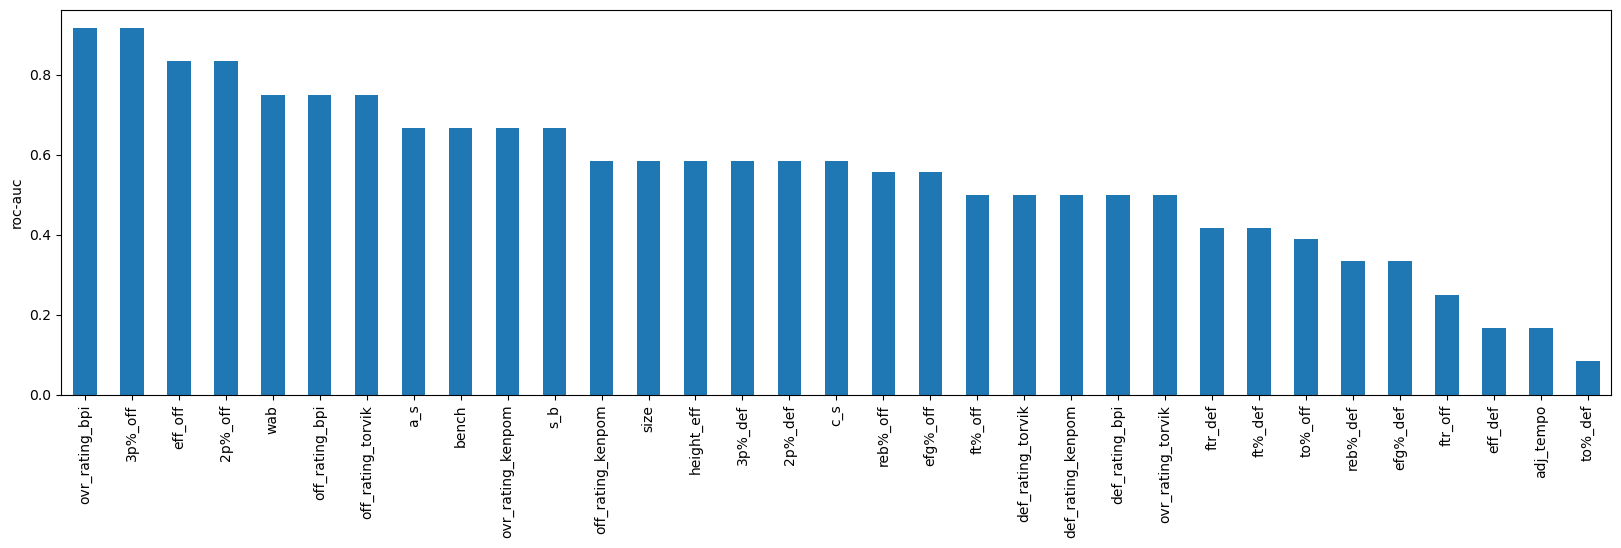

In [108]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [109]:
len(roc_values[roc_values > 0.5])

19

In [110]:
len(roc_values[roc_values > 0.6])

11

In [111]:
len(roc_values[roc_values > 0.7])

7

In [112]:
len(roc_values[roc_values > 0.8])

4

In [113]:
len(roc_values[roc_values > 0.9])

2

# X. Feature Selection

In [116]:
model_df = df[[
 'year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'win',
 'ovr_rating_bpi', 
 'ovr_rating_torvik',
 'wab',
 'def_rating_kenpom',
 'to%_off', 
 'ftr_def',
 'ft%_def',
 's_b',
 'c_s']]
model_df.to_csv('model_features_round2_classic_historical.csv')